# Environment Wrapper for Farm

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mcts import MCTS
from agents import * 
import farmgame  # Ensure the farmgame module is imported
from farmgame import *

# Define the FarmEnv class
class FarmEnv:
    def __init__(self, farm: Farm, reward_function=None):
        self.game = farm  # Accept a Farm instance directly
        self.done = False
        self.reward_function = reward_function or self.default_reward

    def reset(self):
        self.game = configure_game()  # Reset the game
        self.done = False
        return self.get_state()

    def step(self, action):
        current_player = self.game.whose_turn()["name"]
        self.game = self.game.take_action(action, inplace=True)  # Apply action
        reward = self.reward_function(self.game, current_player)  # Calculate reward
        self.done = self.game.is_done()  # Check if game is done
        new_state = self.get_state()  # Get the updated state
        return new_state, reward, self.done, {}  # Return updated state

    def get_state(self):
        return self.map

    def render(self):
        self.game.print_farm()

    def default_reward(self, game, player):
        return game.playersDict[player]["score"]

# Training

In [8]:
class QLearningAgent:
    #def __init__(self, learning_rate=0.1, discount_factor=0.99, epsilon=0.8, seed=None):
    def __init__(self, learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, seed=None):
        self.q_table = {}  # Dictionary to store Q-values
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon

        # Random seed for reproducibility (optional)
        self.seed = seed or random.randint(0, 1e6)
        random.seed(self.seed)

        self.current_state = None  # Track the latest full state

    def update(self, state):
        """
        Update the agent with the current state.
        """
        self.current_state = state  # Keep the full state object

        
    def get_state_representation(self, state):
        """
        Convert the state into a hashable representation for the Q-table.
        """
        return hash(str(state))  # Serialize the state to string and hash

    def get_action_representation(self, action):
        """
        Convert the action into a simplified representation for the Q-table.
        """
        return (action.type, action.loc['x'], action.loc['y'])  # Simplified action representation

    def get_q_value(self, state, action):
        """
        Retrieve the Q-value for a given state-action pair.
        """
        state_rep = self.get_state_representation(state)
        #state_rep = action.loc
        action_rep = self.get_action_representation(action)
        return self.q_table.get((state_rep, action_rep), 0.0)

    def choose_action(self):
        """
        Choose an action based on epsilon-greedy policy.
        """
        actions = self.current_state.legal_actions()  # Access legal actions from the full state
        if not actions:
            raise Exception("No legal actions available.")

        if random.random() < self.epsilon:  # Explore
            action = random.choice(actions)
            print(f"Exploring: Chose random action {action}")
            return action

        # Exploit: Choose the best action based on Q-values
        q_values = [self.get_q_value(self.current_state, a) for a in actions]
        max_q_value = max(q_values)
        best_actions = [a for a, q in zip(actions, q_values) if q == max_q_value]
        action = random.choice(best_actions)
        print(f"Exploiting: Chose action {action} with Q-value {max_q_value}")
        return action

    def update_q_value(self, action, reward, next_state):
        """
        Update the Q-value for the given state-action pair using the Q-learning formula.
        """
        # Get hashable representations of the states and action
        state_rep = self.get_state_representation(self.current_state)
        action_rep = self.get_action_representation(action)
        next_state_rep = self.get_state_representation(next_state)

        # Get the maximum Q-value for the next state
        next_actions = next_state.legal_actions()
        max_q_next = max([self.get_q_value(next_state_rep, a) for a in next_actions], default=0)

        # Compute the TD target and error
        td_target = reward + self.discount_factor * max_q_next
        td_error = td_target - self.get_q_value(self.current_state, action)

        # Update the Q-value
        new_q_value = self.get_q_value(self.current_state, action) + self.learning_rate * td_error
        self.q_table[(state_rep, action_rep)] = new_q_value

        # Debug logs
        print(f"Updated Q-value for state-action pair ({action.loc}, {action_rep}): {new_q_value}")
        print(f"Reward: {reward}, TD Target: {td_target}, TD Error: {td_error}")

    def decay_epsilon(self, decay_rate=0.99):
        """
        Decay the exploration rate (epsilon) over time.
        """
        self.epsilon = max(0.01, self.epsilon * decay_rate)
        print(f"Decayed epsilon: {self.epsilon}")


In [9]:
def train_q_learning_agent(env, learning_rate, discount_factor, epsilon, num_episodes=1000, max_steps_per_episode=100):
    # Initialize two Q-learning agents
    agent1 = QLearningAgent(learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon)
    agent2 = QLearningAgent(learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon)

    final_rewards_red = []  # To store the final rewards of the 'red' player
    final_rewards_purple = []  # To store the final rewards of the 'purple' player
    helpful_moves_red = []  # To track the number of helpful moves for the 'red' player
    helpful_moves_purple = []  # To track the number of helpful moves for the 'purple' player
    
    #state = env.reset()  # Reset the environment for a new episode
    state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)

    #done = False
    
    for episode in range(num_episodes):
        # print(f"\nStarting Episode {episode + 1}/{num_episodes}")

        state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
        agent1.update(state)
        agent2.update(state)

        red_helpful_count = 0  # Counter for red's helpful moves
        purple_helpful_count = 0  # Counter for purple's helpful moves

        for step in range(max_steps_per_episode):
            #print("1 State is " + str(agent1.get_state_representation(agent1.current_state)))
            # Agent 1's turn (Red)
            action1 = agent1.choose_action()
            transition = farmgame.Transition(state, action1)
            if transition.is_helping():
                red_helpful_count += 1

            next_state = state.take_action(action1, inplace=True)
            #print("Step taken to " + str(agent1.get_state_representation(agent1.current_state)))
            reward1, done = next_state.reward("red")  # Get reward for the red player
            agent1.update_q_value(action1, reward1, next_state)
            state = next_state

            if done:
                break  # End the episode if the game is over

            # Agent 2's turn (Purple)
            action2 = agent2.choose_action()
            transition = farmgame.Transition(state, action2)
            if transition.is_helping():
                purple_helpful_count += 1

            next_state = state.take_action(action2, inplace=True)
            reward2, done = next_state.reward("purple")  # Get reward for the purple player
            agent2.update_q_value(action2, reward2, next_state)
            state = next_state

            if done:
                break  # End the episode if the game is over

        # Record final rewards at the end of the episode
        red_rwd, _ = state.reward("red")
        purple_rwd, _ = state.reward("purple")
        final_rewards_red.append(red_rwd)
        final_rewards_purple.append(purple_rwd)

        # Record the number of helpful moves
        helpful_moves_red.append(red_helpful_count)
        helpful_moves_purple.append(purple_helpful_count)

        # Decay epsilon for exploration
        agent1.decay_epsilon()
        agent2.decay_epsilon()

        # Log progress every 100 episodes
        if (episode + 1) % 100 == 0:
            avg_red_reward = sum(final_rewards_red[-100:]) / 100
            avg_purple_reward = sum(final_rewards_purple[-100:]) / 100
            print(f"Episode {episode + 1}: Avg Red Reward = {avg_red_reward}, Avg Purple Reward = {avg_purple_reward}")
            print(f"Avg Helpful Moves: Red = {sum(helpful_moves_red[-100:]) / 100}, Purple = {sum(helpful_moves_purple[-100:]) / 100}")

    print("\nTraining completed.")
    return agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple


In [10]:
#farm_instance = configure_game()  # Ensure this function initializes the Farm object correctly
#env = FarmEnv(farm_instance)
#env = Farm(farm_instance)

In [11]:
TheFarm = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
state = TheFarm

done=False

In [52]:
learning_rate=0.15
discount_factor=0.99
epsilon=0.8
agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple = train_q_learning_agent(TheFarm,learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, num_episodes=1000)

Exploring: Chose random action Eggplant00(12,14)
Updated Q-value for state-action pair ({'x': 12, 'y': 14}, (<ActionType.veggie: 'veggie'>, 12, 14)): -0.75
Reward: -5, TD Target: -5.0, TD Error: -5.0
Exploring: Chose random action Turnip00(12,13)
Updated Q-value for state-action pair ({'x': 12, 'y': 13}, (<ActionType.veggie: 'veggie'>, 12, 13)): -15.0
Reward: -100, TD Target: -100.0, TD Error: -100.0
Exploring: Chose random action redpillow(12,14)
Updated Q-value for state-action pair ({'x': 12, 'y': 14}, (<ActionType.pillow: 'pillow'>, 12, 14)): -15.0
Reward: -100, TD Target: -100.0, TD Error: -100.0
Exploring: Chose random action Strawberry01(8,8)
Updated Q-value for state-action pair ({'x': 8, 'y': 8}, (<ActionType.veggie: 'veggie'>, 8, 8)): -0.75
Reward: -5, TD Target: -5.0, TD Error: -5.0
Exploring: Chose random action Tomato00(8,7)
Updated Q-value for state-action pair ({'x': 8, 'y': 7}, (<ActionType.veggie: 'veggie'>, 8, 7)): -15.0
Reward: -100, TD Target: -100.0, TD Error: -100

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



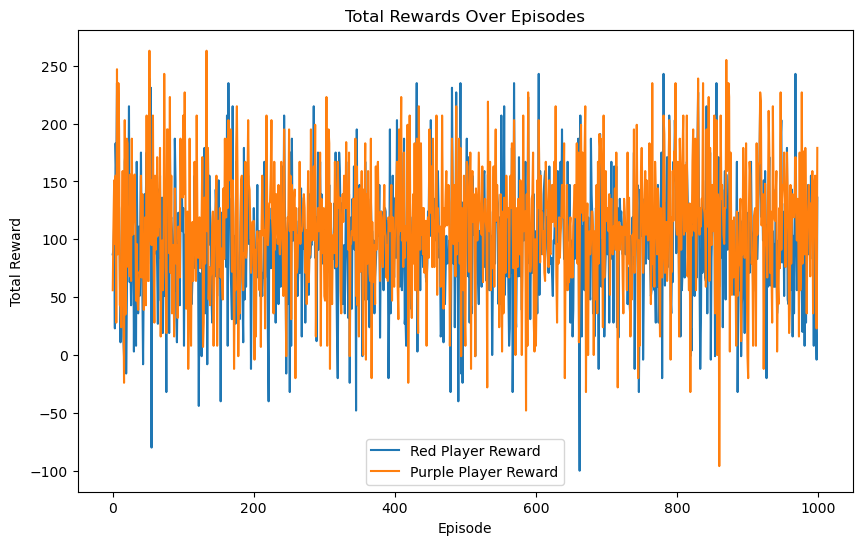

0.004900324900324926
0.009593475593475618


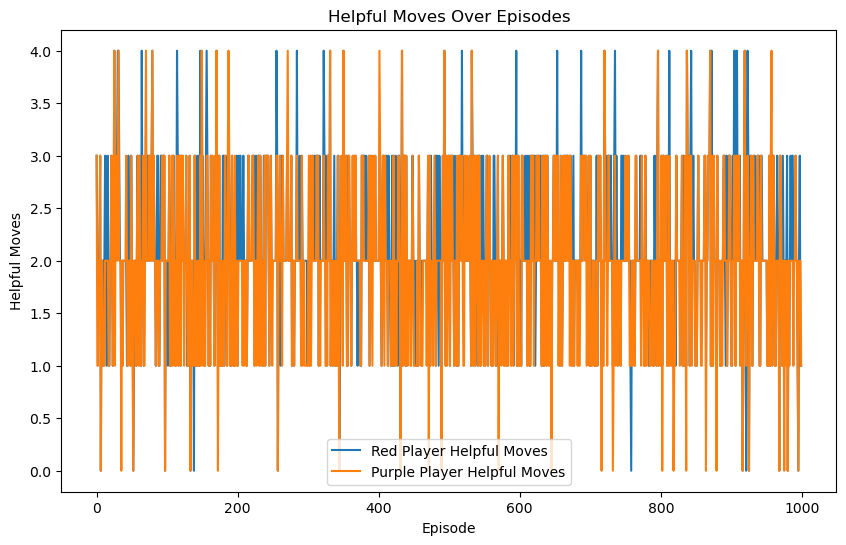

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(final_rewards_red, label="Red Player Reward")
plt.plot(final_rewards_purple, label="Purple Player Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards Over Episodes")
plt.legend()
plt.show()
# Generate x values (indices of the original values)
x = np.arange(len(final_rewards_red))

# Calculate the line of best fit
coefficients = np.polyfit(x, final_rewards_red, 1)
line_of_best_fit = np.poly1d(coefficients)

slope = coefficients[0]
print(slope)

# Calculate the line of best fit
coefficients = np.polyfit(x, final_rewards_purple, 1)
line_of_best_fit = np.poly1d(coefficients)

slope = coefficients[0]
print(slope)

# Example: Plot helpful moves
plt.figure(figsize=(10, 6))
plt.plot(helpful_moves_red, label="Red Player Helpful Moves")
plt.plot(helpful_moves_purple, label="Purple Player Helpful Moves")
plt.xlabel("Episode")
plt.ylabel("Helpful Moves")
plt.title("Helpful Moves Over Episodes")
plt.legend()
plt.show()


In [54]:
def OLS(values):
    # Generate x values (indices of the original values)
    x = np.arange(len(values))

    # Add a constant to the independent variables matrix for the intercept
    X = sm.add_constant(x)

    # Fit the linear regression model
    model = sm.OLS(values, X)
    results = model.fit()

    # Print the summary
    print(results.summary())

    # Extract slope and its confidence interval
    slope = results.params[1]
    slope_ci = results.conf_int()[1]
    print(f"Slope: {slope}, 95% Confidence Interval: {slope_ci}")

    # Plot the original values
    plt.plot(final_rewards_red, 'o', label='Original values')

    # Plot the line of best fit
    plt.plot(x, results.predict(X), '-', label='Line of Best Fit')

    # Add labels, title, and legend
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Trend of Values with Line of Best Fit')
    plt.legend()
    plt.grid(True)
    plt.show()


In [55]:
total_reward = np.array(final_rewards_red)+np.array(final_rewards_purple)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.241
Date:                Mon, 09 Dec 2024   Prob (F-statistic):              0.135
Time:                        18:30:09   Log-Likelihood:                -5899.6
No. Observations:                1000   AIC:                         1.180e+04
Df Residuals:                     998   BIC:                         1.181e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        200.4993      5.586     35.896      0.0

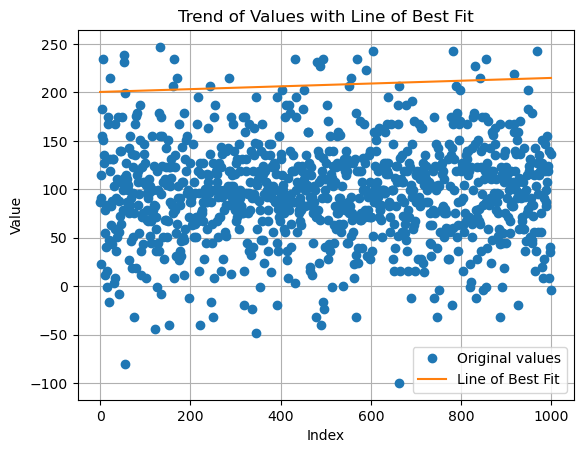

In [56]:
OLS(total_reward)

In [57]:
#Seeing learning!

In [58]:
all_helping = np.array(helpful_moves_red)+np.array(helpful_moves_purple)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3222
Date:                Mon, 09 Dec 2024   Prob (F-statistic):              0.570
Time:                        18:30:11   Log-Likelihood:                -1847.5
No. Observations:                1000   AIC:                             3699.
Df Residuals:                     998   BIC:                             3709.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1247      0.097     42.476      0.0

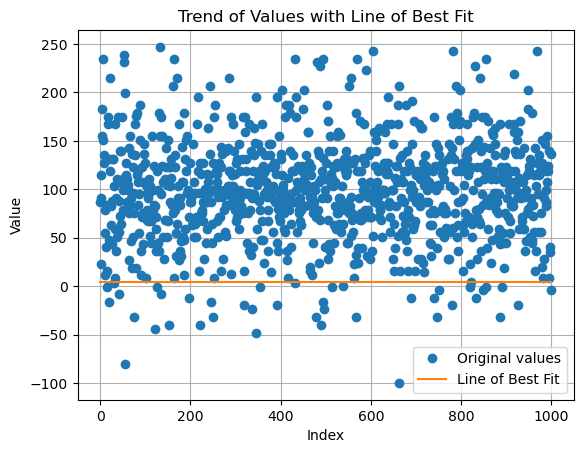

In [59]:
OLS(all_helping)

# walking through step by step 

### setup

In [11]:
agent1 = QLearningAgent(learning_rate=0.15, discount_factor=0.99, epsilon=0.2)
agent2 = QLearningAgent(learning_rate=0.15, discount_factor=0.99, epsilon=0.2)

final_rewards_red = []  # To store the final rewards of the 'red' player
final_rewards_purple = []  # To store the final rewards of the 'purple' player
helpful_moves_red = []  # To track the number of helpful moves for the 'red' player
helpful_moves_purple = []  # To track the number of helpful moves for the 'purple' player

#state = env.reset()  # Reset the environment for a new episode
state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)

#done = False

In [12]:
state.redplayer

{'loc': {'x': 2, 'y': 15},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 0,
 'energy': 100,
 'bonuspoints': 0,
 'has_helped': False}

In [13]:
state.purpleplayer

{'loc': {'x': 3, 'y': 16},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 0,
 'energy': 100,
 'bonuspoints': 0,
 'has_helped': False}

In [14]:
state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
agent1.update(state)
agent2.update(state)

red_helpful_count = 0  # Counter for red's helpful moves
purple_helpful_count = 0  # Counter for purple's helpful moves


### Red takes a step

In [70]:
action1 = agent1.choose_action()
transition = farmgame.Transition(state, action1)
if transition.is_helping():
    red_helpful_count += 1

next_state = state.take_action(action1, inplace=True)
#print("Step taken to " + str(agent1.get_state_representation(agent1.current_state)))
reward1, done = next_state.reward("red")  # Get reward for the red player
agent1.update_q_value(action1, reward1, next_state)
state = next_state

Exploiting: Chose action Eggplant00(12,14) with Q-value 0.0
Updated Q-value for state-action pair ({'x': 12, 'y': 14}, (<ActionType.veggie: 'veggie'>, 12, 14)): -1.0
Reward: -5, TD Target: -5.0, TD Error: -5.0


In [71]:
state.redplayer

{'loc': {'x': 12, 'y': 14},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [<farmgame.Action at 0x1603f2e10>],
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x1603f2e10>]},
 'score': 0,
 'energy': 89,
 'bonuspoints': 0,
 'has_helped': True}

In [10]:
## so red slept, same spot

In [11]:
# Agent 2's turn (Purple)
action2 = agent2.choose_action()
transition = farmgame.Transition(state, action2)
if transition.is_helping():
    purple_helpful_count += 1

next_state = state.take_action(action2, inplace=True)
reward2, done = next_state.reward("purple")  # Get reward for the purple player
agent2.update_q_value(action2, reward2, next_state)
state = next_state

Actions: 
(<ActionType.veggie: 'veggie'>, 8, 7)
(<ActionType.veggie: 'veggie'>, 12, 13)
(<ActionType.veggie: 'veggie'>, 8, 8)
(<ActionType.veggie: 'veggie'>, 7, 7)
(<ActionType.veggie: 'veggie'>, 12, 14)
(<ActionType.veggie: 'veggie'>, 7, 8)
(<ActionType.veggie: 'veggie'>, 13, 14)
(<ActionType.pillow: 'pillow'>, 3, 16)
Exploiting: Chose action Strawberry01(8,8) with Q-value 0.0
Updated Q-value for state-action pair (-958884120165779611, (<ActionType.veggie: 'veggie'>, 8, 8)): -1.0
Reward: -5, TD Target: -5.0, TD Error: -5.0


In [12]:
state.purpleplayer

{'loc': {'x': 8, 'y': 8},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x1074b2210>]},
 'score': 0,
 'energy': 87,
 'bonuspoints': 0,
 'has_helped': True}

In [13]:
# We see purple moved to turnip, but why does it have same backpack capacity
#We see it has backpack content now. So it should be picked up and capacity has not been updated



In [14]:
action1 = agent1.choose_action()
transition = farmgame.Transition(state, action1)
if transition.is_helping():
    red_helpful_count += 1

next_state = state.take_action(action1, inplace=True)
#print("Step taken to " + str(agent1.get_state_representation(agent1.current_state)))
reward1, done = next_state.reward("red")  # Get reward for the red player
agent1.update_q_value(action1, reward1, next_state)
state = next_state
state.redplayer

Actions: 
(<ActionType.veggie: 'veggie'>, 8, 7)
(<ActionType.veggie: 'veggie'>, 12, 13)
(<ActionType.veggie: 'veggie'>, 7, 7)
(<ActionType.veggie: 'veggie'>, 12, 14)
(<ActionType.veggie: 'veggie'>, 7, 8)
(<ActionType.veggie: 'veggie'>, 13, 14)
(<ActionType.box: 'box'>, 16, 5)
(<ActionType.pillow: 'pillow'>, 13, 13)
Exploiting: Chose action Tomato00(8,7) with Q-value 0.0
Updated Q-value for state-action pair (-958884120165779611, (<ActionType.veggie: 'veggie'>, 8, 7)): -20.0
Reward: -100, TD Target: -100.0, TD Error: -100.0


{'loc': {'x': 8, 'y': 7},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [<farmgame.Action at 0x1074b2150>,
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x1074b2150>,
   <farmgame.Action at 0x1074b3a50>]},
 'score': 0,
 'energy': 76,
 'bonuspoints': 0,
 'has_helped': True}

In [15]:
# Agent 2's turn (Purple)
action2 = agent2.choose_action()
transition = farmgame.Transition(state, action2)
if transition.is_helping():
    purple_helpful_count += 1

next_state = state.take_action(action2, inplace=True)
reward2, done = next_state.reward("purple")  # Get reward for the purple player
agent2.update_q_value(action2, reward2, next_state)
state = next_state
state.purpleplayer

Actions: 
(<ActionType.veggie: 'veggie'>, 12, 13)
(<ActionType.veggie: 'veggie'>, 7, 7)
(<ActionType.veggie: 'veggie'>, 12, 14)
(<ActionType.veggie: 'veggie'>, 7, 8)
(<ActionType.veggie: 'veggie'>, 13, 14)
(<ActionType.box: 'box'>, 16, 5)
(<ActionType.pillow: 'pillow'>, 8, 8)
Exploiting: Chose action purplepillow(8,8) with Q-value 0.0
Updated Q-value for state-action pair (-958884120165779611, (<ActionType.pillow: 'pillow'>, 8, 8)): -20.0
Reward: -100, TD Target: -100.0, TD Error: -100.0


{'loc': {'x': 8, 'y': 8},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x1074b2210>]},
 'score': 0,
 'energy': 82,
 'bonuspoints': 0,
 'has_helped': True}

In [52]:
state.all_objects_picked_up('purple')

False

In [ ]:
#now it should have two things in the backpack? Only 1?
#why is the location the same if it went to eggplant?
